In [63]:
# Import of relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [64]:
# Load the email dataset
df = pd.read_csv("data/enron_spam_data.csv")

In [65]:
df.tail(50)

,Message ID,Subject,Message,Spam/Ham,Date
33666,33666,our psychics have a message for you bait - exc...,having problems seeing the graphics ? please g...,spam,2005-07-27
33667,33667,hey !,purest darted omitted sainthood lopez\nscapego...,spam,2005-07-27
33668,33668,repel your afflictions quicker than before wit...,e - pharmaceutical generically supplies the co...,spam,2005-07-27
33669,33669,cialis has outclassed rivals viagra it ' s peo...,many a man ' s tongue broke his nose .,spam,2005-07-27
33670,33670,have you checked the latest - weekly special y...,select our store and your case details will be...,spam,2005-07-27
33671,33671,have you checked the special pricing on therap...,it is a superb chance for you to reduce spendi...,spam,2005-07-27
33672,33672,first - class qualities . economic pricing . q...,i wasn ' t aware how much e shopping could red...,spam,2005-07-27
33673,33673,= ? iso - 8859 - 1 ? q ? vl = eogrra _ v = eol...,"hello , welcome to megapharm onliine shop .\np...",spam,2005-07-27
33674,33674,yukos oil,"dear friend ,\ni am mr olsom berghart a person...",spam,2005-07-27
33675,33675,"we are the only online pharmacy offering "" 100...",affordable - the way medications should be\nto...,spam,2005-07-27


In [66]:
df.shape

(33716, 5)

In [67]:
# Drop rows with NaNs in the 'Message' column
df = df.dropna(subset=['Message']).copy()

# Combine 'Subject' and 'Message' into a new 'text' column
def combine_subject_message(row):
    subject = row['Subject'] if pd.notna(row['Subject']) else ''
    message = row['Message']
    return f"{subject} {message}".strip()

df['text'] = df.apply(combine_subject_message, axis=1)

In [68]:
df.shape

(33345, 6)

In [69]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Spam/Ham"], shuffle=True)

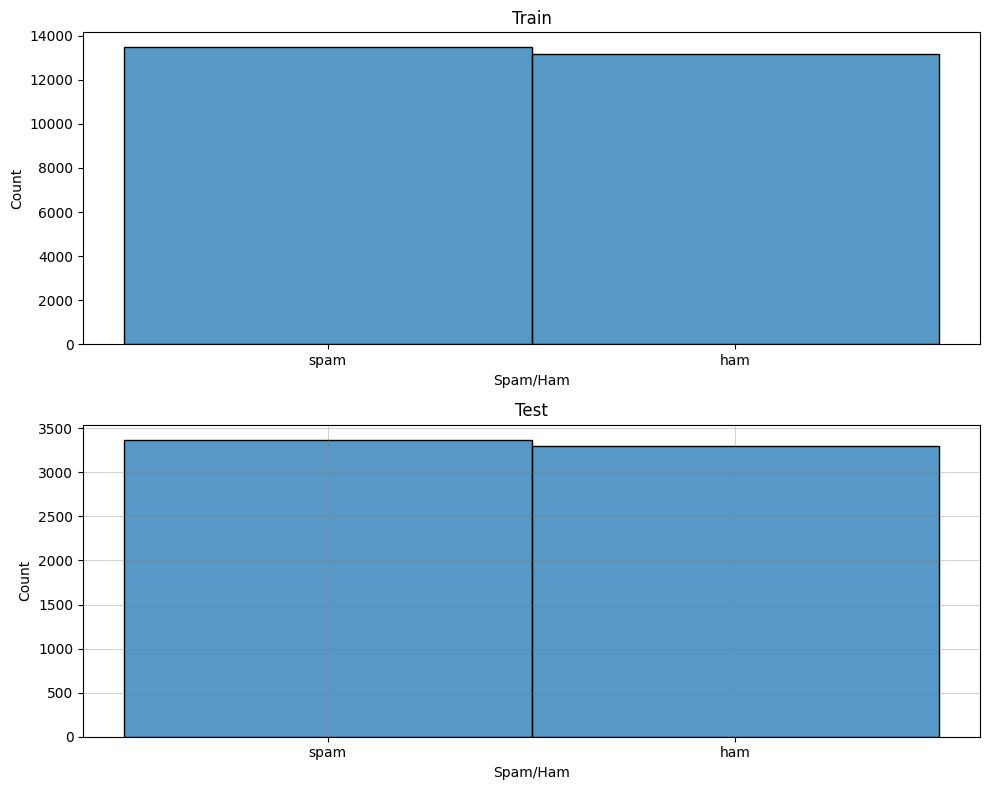

In [70]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

sns.histplot(train_df["Spam/Ham"], ax=axes[0])
axes[0].bar_label(axes[0].containers[0])
axes[0].set_title("Train")

sns.histplot(test_df["Spam/Ham"], ax=axes[1])
axes[1].bar_label(axes[1].containers[0])
axes[1].set_title("Test")
axes[1].grid("both", lw=0.5, alpha=0.3, color="grey")


plt.grid("both", lw=0.5, alpha=0.5, color="grey")
plt.tight_layout()
plt.show()

In [71]:
# Convert Pandas dataframes to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [72]:
# === Step 2: Encode labels as integers ===
labels = list(df["Spam/Ham"].unique())       # e.g., ["Invoice", "Sales", "Support"]
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

In [73]:
def encode_labels(batch):
    batch["Spam/Ham"] = label2id[batch["Spam/Ham"]]
    return batch

train_dataset = train_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)

Map: 100%|██████████| 6669/6669 [00:00<00:00, 11402.61 examples/s]


In [77]:
test_dataset

Dataset({
    features: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date', 'text', '__index_level_0__'],
    num_rows: 6669
})

In [78]:
# === Step 3: Tokenize email text ===

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    # Convert each email text to input IDs and attention masks
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map: 100%|██████████| 6669/6669 [00:27<00:00, 241.84 examples/s]


In [79]:
# === Step 4: Load pre-trained BERT model ===
model = BertForSequenceClassification.from_pretrained(
    "bert-base-german-cased", 
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

for param in model.bert.parameters():
    param.requires_grad = False

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Users\jonat\WaterMLOps\Rubitherm_Capstone\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jonat\.cache\huggingface\hub\models--bert-base-german-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, 

In [82]:
# === Step 5: Define training arguments ===
training_args = TrainingArguments(
    output_dir = "./results",
    eval_strategy = "epoch",             # evaluate after each epoch
    save_strategy = "epoch",             # save model after each epoch
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [ ]:
# === Step 6: Define evaluation metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

In [ ]:


# === Step 7: Create Trainer object ===
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics,
)

In [ ]:
# === Step 8: Train the model ===
trainer.train()

In [ ]:
# === Step 9: Save trained model and tokenizer for future use ===
trainer.save_model("./email-bert-classifier")
tokenizer.save_pretrained("./email-bert-classifier")